# Coördinated Spiking Model

Install required packages

In [1]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d

## Single-neuron

Number of dimensions

In [2]:
d = 2

Initialize parameters

In [87]:
# timesteps
dt = 0.01
iterations = 200
t = np.arange(0, iterations) * dt

# voltage
voltage = np.zeros(iterations)

# input estimate
x_est = np.zeros((d, iterations))

# spike train
o = np.zeros(iterations)

# spike times
spike = []
t_spike = []

# input signal
x = [0.5, 0.5]

# decoding weights
D = np.zeros(d)
D[0] = 0.5
D[1] = 0.5

# threshold
T = np.dot(D, D) / 2
print(T)

0.25


In [88]:
for t in range(1, iterations):
    
    # update input estimate
    dxestdt = -x_est[:, t - 1] + o[t - 1] * D.T
    x_est[:, t] = x_est[:, t - 1] + dt * dxestdt
    
    # update voltage
    dVdt = -voltage[t - 1] + np.dot(D, x) - np.dot(D, D) * o[t - 1]
    voltage[t] = voltage[t - 1] + dt * dVdt
    
        # spike when voltage exceeds threshold
    if voltage[t] > T:
        o[t] = 1/dt
        
        # save spike times
        spike.append(1)
        t_spike.append(t)


(0, 200)

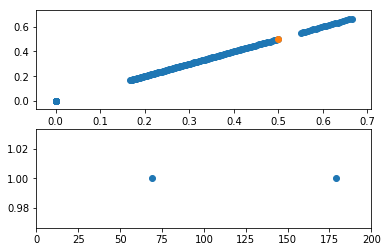

In [90]:

pl.subplot(2, 1, 1)
pl.scatter(x_est[0, :], x_est[1, :])
pl.scatter(x[0], x[1])

pl.subplot(2, 1, 2)
pl.scatter(t_spike, spike)
pl.xlim(0, 200)


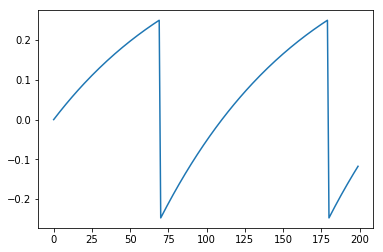

In [80]:
pl.plot(voltage)

In [81]:
print(voltage)
print(x_est)

[ 0.00000000e+00  5.00000000e-03  9.95000000e-03  1.48505000e-02
  1.97019950e-02  2.45049750e-02  2.92599253e-02  3.39673260e-02
  3.86276528e-02  4.32413763e-02  4.78089625e-02  5.23308729e-02
  5.68075641e-02  6.12394885e-02  6.56270936e-02  6.99708227e-02
  7.42711145e-02  7.85284033e-02  8.27431193e-02  8.69156881e-02
  9.10465312e-02  9.51360659e-02  9.91847052e-02  1.03192858e-01
  1.07160930e-01  1.11089320e-01  1.14978427e-01  1.18828643e-01
  1.22640356e-01  1.26413953e-01  1.30149813e-01  1.33848315e-01
  1.37509832e-01  1.41134734e-01  1.44723386e-01  1.48276153e-01
  1.51793391e-01  1.55275457e-01  1.58722702e-01  1.62135475e-01
  1.65514121e-01  1.68858980e-01  1.72170390e-01  1.75448686e-01
  1.78694199e-01  1.81907257e-01  1.85088184e-01  1.88237303e-01
  1.91354930e-01  1.94441380e-01  1.97496966e-01  2.00521997e-01
  2.03516777e-01  2.06481609e-01  2.09416793e-01  2.12322625e-01
  2.15199399e-01  2.18047405e-01  2.20866931e-01  2.23658261e-01
  2.26421679e-01  2.29157

In [86]:
print(t_spike)

[]
